In [6]:
# import spacy

# using spacy to detect medication names
# !pip3 install pandas seaborn scikit-learn nltk;
# nlp = spacy.load('en_core_web_md'); # load the model
#med_nlp = spacy.load("en_core_sci_md-0.5.1")


In [7]:
import pandas as pd
import re
import tqdm
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# get stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
# ignore SettingWithCopyWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [10]:
df = pd.read_csv('./data/reddit_threads.csv')

In [11]:
# pandas show all cols
pd.set_option('display.max_columns', None)

In [12]:
# Question: How many posts mention sexual topics in the selftext?
df['sexual_factor'].value_counts(normalize=True)

KeyError: 'sexual_factor'

96.8% of the posts in the `df` (combined) subreddit did not have a `sexual factor` in them. This is a low percentage. This means that these terms are not likely to be causing any overfitting which is good news for the model's prediction quality. 

In [ ]:
df_aut['sexual_factor'].value_counts(normalize=True)

False    0.987977
True     0.012023
Name: sexual_factor, dtype: float64

Only 1.2% of the posts in the `Autism` subreddit have a `sexual factor` in them. This is very small and considering that the `OCD` subreddit has a percentage of 2.8% the sexual factor is not a significant biasing factor in the data. The words will be removed to ensure that the model is not overfitting to the data though.

Titles

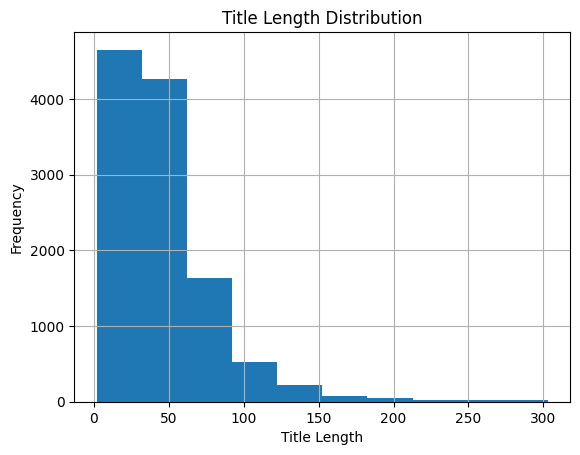

In [ ]:
df['title_length'].hist()
plt.title('Title Length Distribution')
plt.ylabel('Frequency')
plt.xlabel('Title Length')
plt.savefig('../images/title_length_distribution.png');

Title lengths taper off around 125 to 150.

# Do medication names skew towards one thread over the other?

In [ ]:
listofknown_medications = [
    'clonidine', 'quetiapine', 'risperidone', 'vyvanse', 'adderall', 'dexedrine', 'wellbutrin', 'focalinxr', 'modafanil', 'fluvoxamine', 'serzone', 'fluvoxamine', 'prozac', 'lexapro', 'paxil', 'celexa', 'effexor', 'zoloft', 'cymbalta', 'luvox', 'pristiq', 'remeron', 'venlafaxine', 'sarafem', 'anafranil', 'nortriptyline', 'tofranil', 'xanax', 'klonopin', 'ativan', 'valium', 'buspirone', 'oxazepam', 'aripiprazole', 'dextroamphetamine', 'ssrisnri', 'clonazepam', 'lorazepam', 'temazepam', 'alprazolam', 'chlordiazepoxide', 'flurazepam', 'oxazepam', 'triazolam', 'divalproexsodium', 'dronabinol', 'nabilone', 'duloxetine',"Atorvastatin", "Levothyroxine", "Metformin", "Lisinopril", "Amlodipine", "Metoprolol", "Albuterol", "Omeprazole", "Losartan", "Gabapentin", "Hydrochlorothiazide", "Sertraline", "Simvastatin", "Montelukast", "Escitalopram", "Acetaminophen; Hydrocodone", "Rosuvastatin", "Bupropion", "Furosemide", "Pantoprazole", "Trazodone", "Dextroamphetamine; Dextroamphetamine Saccharate; Amphetamine; Amphetamine Aspartate", "Fluticasone", "Tamsulosin", "Fluoxetine", "Carvedilol", "Duloxetine", "Meloxicam", "Clopidogrel", "Prednisone", "Citalopram", "Insulin Glargine", "Potassium Chloride", "Pravastatin", "Tramadol", "Aspirin", "Alprazolam", "Ibuprofen", "Cyclobenzaprine", "Amoxicillin", "Methylphenidate", "Allopurinol", "Venlafaxine", "Clonazepam", "Ethinyl Estradiol; Norethindrone", "Ergocalciferol", "Zolpidem", "Apixaban", "Glipizide", "Hydrochlorothiazide; Lisinopril", "Spironolactone", "Cetirizine", "Atenolol", "Oxycodone", "Buspirone", "Fluticasone; Salmeterol", "Topiramate", "Warfarin", "Estradiol", "Cholecalciferol", "Budesonide; Formoterol", "Lamotrigine", "Ethinyl Estradiol; Norgestimate", "Quetiapine", "Lorazepam", "Famotidine", "Folic Acid", "Azithromycin", "Acetaminophen; Oxycodone", "Hydroxyzine", "Insulin Lispro", "Diclofenac", "Loratadine", "Sitagliptin", "Clonidine", "Diltiazem", "Latanoprost", "Pregabalin", "Doxycycline", "Insulin Aspart", "Amitriptyline", "Paroxetine", "Ondansetron", "Tizanidine", "Lisdexamfetamine", "Rivaroxaban", "Glimepiride", "Propranolol", "Aripiprazole", "Finasteride", "Naproxen", "Levetiracetam", "Hydrochlorothiazide; Losartan", "Alendronate", "Fenofibrate", "Dulaglutide", "Oxybutynin", "Celecoxib", "Lovastatin", "Ezetimibe", "Cephalexin", "Empagliflozin", "Hydralazine", "Mirtazapine", "Cyanocobalamin", "Triamcinolone", "Amoxicillin; Clavulanate", "Baclofen", "Valproate", "Tiotropium", "Sumatriptan", "Donepezil", "Methotrexate", "Isosorbide", "Fluticasone; Vilanterol", "Ferrous Sulfate", "Thyroid", "Acetaminophen", "Valacyclovir", "Desogestrel; Ethinyl Estradiol", "Sulfamethoxazole; Trimethoprim", "Esomeprazole", "Valsartan", "Insulin Detemir", "Clindamycin", "Hydroxychloroquine", "Methocarbamol", "Diazepam", "Semaglutide", "Dexmethylphenidate", "Hydrochlorothiazide; Triamterene", "Ciprofloxacin", "Chlorthalidone", "Rizatriptan", "Nifedipine", "Insulin Degludec", "Norethindrone", "Risperidone", "Olmesartan", "Morphine", "Benazepril", "Meclizine", "Timolol", "Oxcarbazepine", "Drospirenone; Ethinyl Estradiol", "Liraglutide", "Dicyclomine", "Irbesartan", "Hydrocortisone", "Albuterol; Ipratropium", "Verapamil", "Memantine", "Prednisolone", "Metformin; Sitagliptin", "Nortriptyline", "Ropinirole", "Benzonatate", "Progesterone", "Ethinyl Estradiol; Levonorgestrel", "Mirabegron", "Methylprednisolone", "Acyclovir", "Docusate", "Olanzapine", "Nitroglycerin", "Bimatoprost", "Nitrofurantoin", "Pioglitazone", "Amlodipine; Benazepril", "Ketoconazole", "Clobetasol", "Testosterone", "Azelastine", "Fluconazole", "Brimonidine", "Desvenlafaxine", "Ranitidine", "Oseltamivir", "Levocetirizine", "Anastrozole", "Phentermine", "Sucralfate", "Sildenafil", "Mesalamine", "Carbamazepine", "Buprenorphine", "Acetaminophen; Codeine", "Flecainide", "Gemfibrozil", "Prazosin", "Lansoprazole", "Diphenhydramine", "Pramipexole", "Ethinyl Estradiol; Etonogestrel", "Dorzolamide; Timolol", "Ramipril", "Lithium", "Amiodarone", "Omega-3-acid Ethyl Esters", "Glyburide", "Acetaminophen; Butalbital; Caffeine", "Magnesium Salts", "Mupirocin", "Calcium", "Adalimumab", "Methimazole", "Budesonide", "Promethazine", "Doxazosin", "Labetalol", "Terazosin", "Cyclosporine", "Torsemide", "Medroxyprogesterone", "Calcium; Vitamin D", "Dorzolamide", "Dapagliflozin", "Liothyronine", "Sacubitril; Valsartan", "Beclomethasone", "Insulin Isophane", "Metronidazole", "Temazepam", "Fluticasone; Umeclidinium; Vilanterol", "Erythromycin", "Polyethylene Glycol 3350", "Nystatin", "Cefdinir", "Benztropine", "Tretinoin", "Mometasone", "Eszopiclone", "Betamethasone", "Erenumab", "Hydrochlorothiazide; Valsartan", "Minocycline", "Digoxin", "Empagliflozin; Metformin", "Nebivolol", "Levofloxacin", "Colchicine", "Ofloxacin", "Vortioxetine", "Linaclotide", "Umeclidinium", "Insulin Human; Insulin Isophane Human", "Ticagrelor", "Telmisartan", "Ketorolac", "Hydromorphone", "Epinephrine", "Doxepin", "Quinapril", "Umeclidinium; Vilanterol", "Fexofenadine", "Brimonidine; Timolol", "Letrozole", "Ranolazine", "Lurasidone", "Phenytoin", "Tadalafil", "Pancrelipase Amylase; Pancrelipase Lipase; Pancrelipase Protease", "Dexlansoprazole", "Isotretinoin", "Sodium Fluoride", "Solifenacin", "Bisoprolol", "Olopatadine", "Primidone", "Bumetanide", "Tolterodine", "Dexamethasone", "Chlorhexidine", "Sodium Salts", "Varenicline", "Zonisamide", "Calcitriol", "Emtricitabine; Tenofovir Disoproxil", "Terbinafine", "Fluocinonide", "Hydrochlorothiazide; Olmesartan", "Ziprasidone", "Estrogens, Conjugated", "Sulfasalazine", "Icosapent Ethyl", "Dexamethasone; Moxifloxacin", "Atomoxetine", "Formoterol; Mometasone", "Ketotifen", "Bisoprolol; Hydrochlorothiazide", "Sennosides", "Raloxifene", "Linagliptin", "Canagliflozin", "Alogliptin", "Sotalol", "Potassium Citrate", "Melatonin", "Isosorbide Dinitrate", "Guanfacine"]

listofknown_medications = [x.lower() for x in listofknown_medications] # make all the words lowercase

def remove_ocd_meds(text,listofknown_medications):
    global meds
    if len(meds)> 0:
        print(meds[-1], " is the latest medication")
    wordsintext = text.split(' ')

    for word in wordsintext:
        if word in listofknown_medications:
            meds.append(word)
            text = text.replace(word,' ')
    # remove if any words in text are in list of known medications
    return text

# create a new col in df that is boolean to indicate if any word in the selftext is in the list of known medications and is not a space or a ' or a comma
df['medication_mentioned'] = df['selftext'].apply(lambda x: any(word in listofknown_medications for word in x.split(' ') if word not in [' ','\'',',']))
print(f'The meds mentioned column has been intialized with {df["medication_mentioned"].sum()} rows that mention medications.')
meds = [] # initialize list of meds

dfss = df[df['medication_mentioned'] == True]
# which subthreads mention medications?
dfss['is_autism'].value_counts(normalize=True)


# https://clincalc.com/DrugStats/Top300Drugs.aspx - list of top 300 drugs

The meds mentioned column has been intialized with 141 rows that mention medications.


0    0.836879
1    0.163121
Name: is_autism, dtype: float64

This shows that ocd has a higher percentage of posts with medication names in them. It is good that we are eliminating these words from the model's vocabulary. It will limit the overfitting of the model to the data.

### What are the most common words found in posts from the `OCD` subreddit?

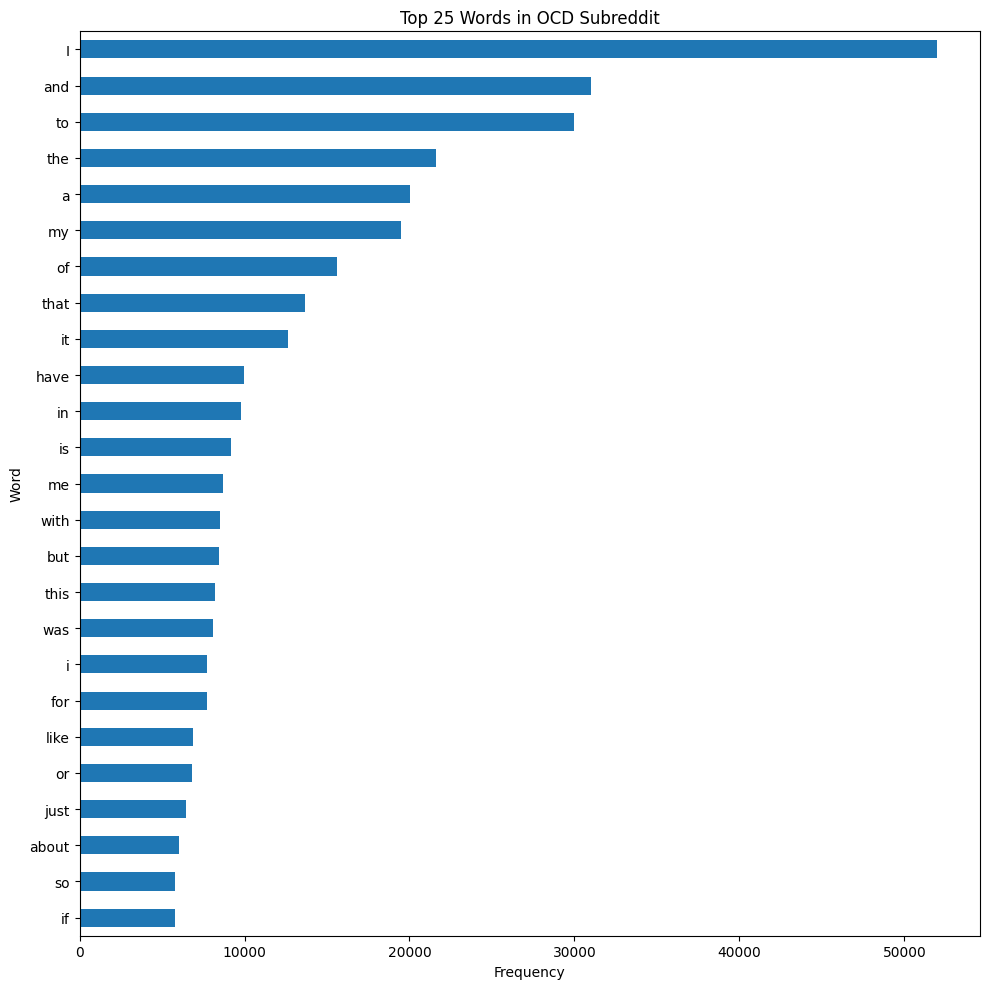

In [ ]:
top_25_words_ocd = df_ocd['selftext'].str.split(expand=True).stack().value_counts()[:25].sort_values(ascending=True)
top_25_words_ocd.plot(kind='barh', figsize=(10,10))
plt.title('Top 25 Words in OCD Subreddit')
plt.ylabel('Word')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('../images/top_25_words_ocd.png');


I and to the... and other basic stop words are the most common words in the `OCD` subreddit. 

# Summary Statistics

In [ ]:
df.describe()

,created_utc,num_comments,retrieved_on,subreddit_subscribers,word_count,title_word_count,unique_word_count,title_unique_word_count,post_length,title_length,gunning_fog,smog_index,reading_time,sentence_count,lexicon_count,positive_sentiment,negative_sentiment,neutral_sentiment,compound_sentiment,is_autism,title_caps,title_sentiment_comp
count,1.147800e+04,11478.000000,1.147800e+04,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000,11478.000000
mean,1.581265e+09,7.379509,1.581269e+09,67218.777574,163.370971,8.326712,100.940408,8.022216,879.119010,46.758669,16.934832,7.271920,10.463309,6.521432,163.666144,0.111747,0.107080,0.780913,0.001030,0.500000,0.515072,-0.020877
std,2.387695e+07,11.349183,2.387945e+07,28195.792500,198.028617,6.488311,85.143122,5.815925,1055.928388,34.817361,22.384763,5.377159,12.542556,10.841441,197.941512,0.079078,0.080099,0.097999,0.755251,0.500022,0.854843,0.348886
min,1.546783e+09,0.000000,1.546783e+09,30079.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.999800,0.000000,0.000000,-0.977300
25%,1.562036e+09,2.000000,1.562036e+09,45481.500000,56.000000,4.000000,45.000000,4.000000,301.000000,24.000000,8.780000,0.000000,3.580000,2.000000,56.000000,0.062000,0.050000,0.724000,-0.817450,0.000000,0.000000,-0.226300
50%,1.577132e+09,4.000000,1.577132e+09,58787.000000,108.000000,7.000000,79.000000,7.000000,581.000000,38.000000,11.610000,8.800000,6.930000,4.000000,108.000000,0.102000,0.098000,0.784000,0.000000,0.500000,0.000000,0.000000
75%,1.594895e+09,9.000000,1.594895e+09,81523.500000,203.000000,11.000000,132.000000,10.000000,1096.000000,59.000000,16.337500,11.200000,13.070000,8.000000,204.000000,0.149000,0.152000,0.842000,0.801150,1.000000,1.000000,0.025800
max,1.636070e+09,272.000000,1.636070e+09,132820.000000,4960.000000,63.000000,1271.000000,52.000000,25430.000000,303.000000,480.210000,45.100000,304.610000,768.000000,4989.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,0.980900


In [ ]:
# df for autism
df_autism = df[df['is_autism'] == True]
df_autism.describe()

,created_utc,num_comments,retrieved_on,subreddit_subscribers,word_count,title_word_count,unique_word_count,title_unique_word_count,post_length,title_length,gunning_fog,smog_index,reading_time,sentence_count,lexicon_count,positive_sentiment,negative_sentiment,neutral_sentiment,compound_sentiment,is_autism,title_caps,title_sentiment_comp
count,5.739000e+03,5739.000000,5.739000e+03,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.0,5739.000000,5739.000000
mean,1.570225e+09,10.692978,1.570229e+09,53684.944415,154.909043,8.524830,98.612302,8.217285,844.265726,48.205959,16.533708,7.219655,10.069655,6.107336,155.243771,0.119694,0.084395,0.795745,0.207553,1.0,0.374107,0.032082
std,1.401184e+07,12.906702,1.401877e+07,11490.765019,173.648582,6.406787,82.653388,5.752203,941.910900,34.371047,21.002886,5.439152,11.218847,7.008409,173.653957,0.083258,0.071399,0.095006,0.718472,0.0,0.737129,0.332527
min,1.546787e+09,0.000000,1.546787e+09,35175.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.999500,1.0,0.000000,-0.926000
25%,1.558390e+09,4.000000,1.558390e+09,44184.500000,54.000000,4.000000,44.500000,4.000000,294.000000,26.000000,8.845000,0.000000,3.530000,2.000000,54.000000,0.066000,0.032000,0.740000,-0.531050,1.0,0.000000,0.000000
50%,1.569425e+09,7.000000,1.569425e+09,52193.000000,102.000000,7.000000,77.000000,7.000000,558.000000,40.000000,11.760000,8.800000,6.670000,4.000000,102.000000,0.109000,0.075000,0.799000,0.440400,1.0,0.000000,0.000000
75%,1.581180e+09,13.000000,1.581180e+09,62142.000000,193.000000,11.000000,129.000000,11.000000,1051.000000,61.000000,16.430000,11.200000,12.470000,8.000000,193.000000,0.161000,0.122000,0.854000,0.893400,1.0,1.000000,0.226300
max,1.596630e+09,210.000000,1.596630e+09,77684.000000,2400.000000,63.000000,928.000000,50.000000,14176.000000,300.000000,480.210000,38.600000,171.840000,108.000000,2432.000000,1.000000,1.000000,1.000000,0.999700,1.0,11.000000,0.980900


The descriptive statistics for the `OCD` subreddit are shown above. Data quality is not great because if you examine the subscribers, and try to interpret this it may be difficult. 

In [ ]:
print(f'The post lengths in the autism subreddit are {df_autism["post_length"].mean()} characters on average and {df_autism["post_length"].median()} characters in the median.')

The post lengths in the autism subreddit are 844.265725736191 characters on average and 558.0 characters in the median.


In [ ]:
# df for ocd
df_ocd = df[df['is_autism'] == False]
df_ocd.describe()

,created_utc,num_comments,retrieved_on,subreddit_subscribers,word_count,title_word_count,unique_word_count,title_unique_word_count,post_length,title_length,...,reading_time,sentence_count,lexicon_count,positive_sentiment,negative_sentiment,neutral_sentiment,compound_sentiment,is_autism,title_caps,title_sentiment_comp
count,5.739000e+03,5739.000000,5.739000e+03,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,...,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.000000,5739.0,5739.000000,5739.000000
mean,1.592305e+09,4.066039,1.592308e+09,80752.610734,171.832898,8.128594,103.268514,7.827148,913.972295,45.311378,...,10.856963,6.935529,172.088517,0.103800,0.129765,0.766082,-0.205493,0.0,0.656038,-0.073836
std,2.646075e+07,8.311762,2.646242e+07,33041.083162,219.409291,6.563404,87.507378,5.872981,1157.815946,35.201557,...,13.729033,13.624733,219.250812,0.073821,0.081888,0.098707,0.734430,0.0,0.937301,0.356762
min,1.546783e+09,0.000000,1.546783e+09,30079.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.999800,0.0,0.000000,-0.977300
25%,1.569422e+09,1.000000,1.569422e+09,50298.000000,58.000000,4.000000,47.000000,4.000000,308.000000,23.000000,...,3.670000,2.000000,58.000000,0.058000,0.075000,0.708000,-0.913000,0.0,0.000000,-0.340000
50%,1.592595e+09,2.000000,1.592599e+09,81524.000000,114.000000,6.000000,81.000000,6.000000,605.000000,36.000000,...,7.170000,4.000000,114.000000,0.095000,0.124000,0.769000,-0.451500,0.0,0.000000,0.000000
75%,1.615486e+09,5.000000,1.615486e+09,111145.500000,213.000000,10.000000,134.000000,10.000000,1133.000000,57.000000,...,13.410000,8.000000,214.000000,0.138000,0.175000,0.825000,0.569350,0.0,1.000000,0.000000
max,1.636070e+09,272.000000,1.636070e+09,132820.000000,4960.000000,59.000000,1271.000000,52.000000,25430.000000,303.000000,...,304.610000,768.000000,4989.000000,1.000000,0.955000,1.000000,1.000000,0.0,13.000000,0.951700


#note: I do see that there are outliers here that I need to process. I will improve on this in the next few weeks as I add to this on my portfolio.

In [ ]:
print(f'The post lengths in the ocd subreddit are {df_ocd["post_length"].mean()} characters on average and {df_ocd["post_length"].median()} characters in the median.')

The post lengths in the ocd subreddit are 913.9722948248824 characters on average and 605.0 characters in the median.


* 163.370971 words per post in the combined subreddit.
* The minimum number of words in a post is 1 which is funny.
* The maximum number of words in a post is 25430 which is not funny.
* The avg sentiment score for the titles is -0.02


### What are the most common words found in posts from the `Autism` subreddit?

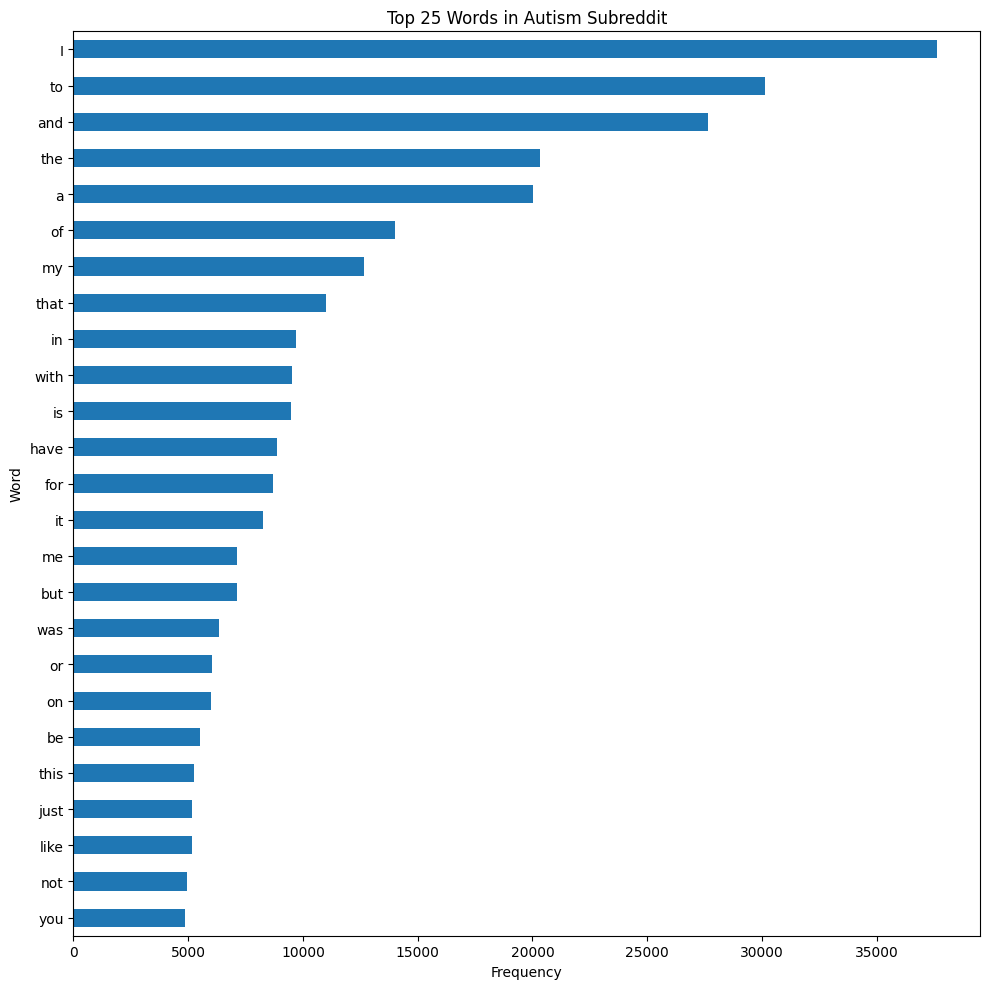

In [ ]:
top_25_words_aut = df_aut['selftext'].str.split(expand=True).stack().value_counts()[:25].sort_values(ascending=True)
top_25_words_aut.plot(kind='barh', figsize=(10,10))
plt.title('Top 25 Words in Autism Subreddit')
plt.ylabel('Word')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('../images/top_25_words_aut.png');

The same is true for the `Autism` subreddit.

What are the most common bigrams found in posts from the `OCD` subreddit?


In [ ]:
# most common bigrams
from collections import Counter
from nltk.util import ngrams
# import count vectorizer
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]




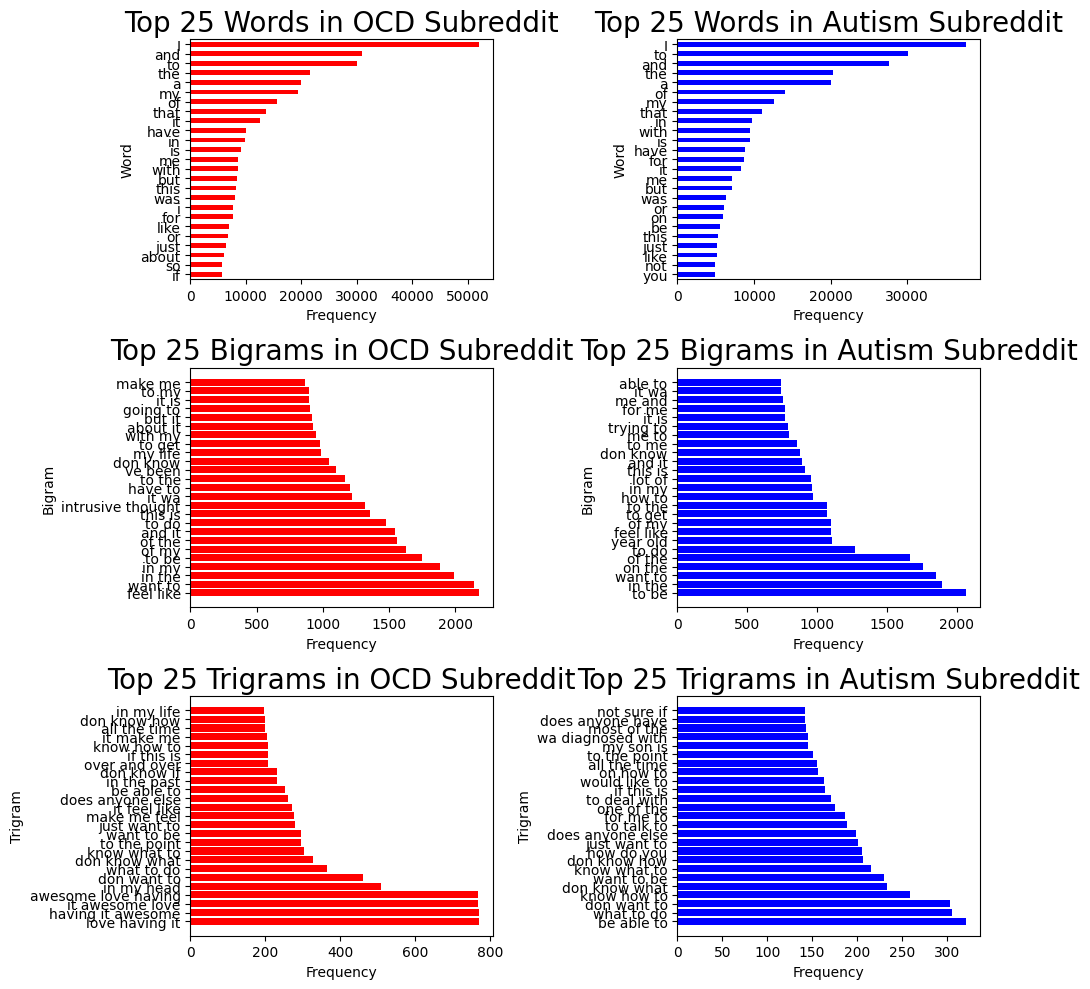

In [ ]:
# Figure Design
# A six panel Figure
# Figure (1,0) - Top 25 words in OCD subreddit word cloud
# specs: a barplot sorted ascending=False with a title, x and y labels
# colors: bright red
# Figure (1,1) - Top 25 words in Autism subreddit word cloud
# specs: a barplot sorted ascending=False with a title, x and y labels
# colors: bright blue
# Figure (2,0) - Top 25 bigrams in OCD subreddit
# specs: a barplot sorted ascending=False with a title, x and y labels
# colors: bright red
# Figure (2,1) - Top 25 bigrams in Autism subreddit
# specs: a barplot sorted ascending=False with a title, x and y labels
# colors: bright blue
# Figure (3,0) - Top 25 trigrams in OCD subreddit
# specs: a barplot sorted ascending=False with a title, x and y labels
# colors: bright red
# Figure (3,1) - Top 25 trigrams in Autism subreddit
# specs: a barplot sorted ascending=False with a title, x and y labels
# colors: bright blue

# Figure Code:
figure = plt.figure(figsize=(50,30))
# Figure (1,0) - Top 25 words in OCD subreddit word cloud
ax1 = figure.add_subplot(3,2,1)
top_25_words_ocd.plot(kind='barh', figsize=(10,10), color='red')
plt.title('Top 25 Words in OCD Subreddit', fontsize=20)
plt.ylabel('Word', fontsize=10)
plt.xlabel('Frequency', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Figure (1,1) - Top 25 words in Autism subreddit word cloud
ax2 = figure.add_subplot(3,2,2)
top_25_words_aut.plot(kind='barh', figsize=(10,10), color='blue')
plt.title('Top 25 Words in Autism Subreddit', fontsize=20)
plt.ylabel('Word', fontsize=10)
plt.xlabel('Frequency', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Figure (2,0) - Top 25 bigrams in OCD subreddit
ax3 = figure.add_subplot(3,2,3)
top_25_bigrams_ocd = get_top_n_bigram(df_ocd['selftext_lemmatized'], 25)
x_ocd, y_ocd = map(list, zip(*top_25_bigrams_ocd))
plt.barh(x_ocd, y_ocd, color='red')
plt.title('Top 25 Bigrams in OCD Subreddit', fontsize=20)
plt.ylabel('Bigram', fontsize=10)
plt.xlabel('Frequency', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Figure (2,1) - Top 25 bigrams in Autism subreddit
ax4 = figure.add_subplot(3,2,4)
top_25_bigrams_aut = get_top_n_bigram(df_aut['selftext_lemmatized'], 25)
x_aut, y_aut = map(list, zip(*top_25_bigrams_aut))
plt.barh(x_aut, y_aut, color='blue')
plt.title('Top 25 Bigrams in Autism Subreddit', fontsize=20)
plt.ylabel('Bigram', fontsize=10)
plt.xlabel('Frequency', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Figure (3,0) - Top 25 trigrams in OCD subreddit
ax5 = figure.add_subplot(3,2,5)
top_25_trigrams_ocd = get_top_n_trigram(df_ocd['selftext_lemmatized'], 25)
x_ocd, y_ocd = map(list, zip(*top_25_trigrams_ocd))
plt.barh(x_ocd, y_ocd, color='red')
plt.title('Top 25 Trigrams in OCD Subreddit', fontsize=20)
plt.ylabel('Trigram', fontsize=10)
plt.xlabel('Frequency', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Figure (3,1) - Top 25 trigrams in Autism subreddit
ax6 = figure.add_subplot(3,2,6)
top_25_trigrams_aut = get_top_n_trigram(df_aut['selftext_lemmatized'], 25)
x_aut, y_aut = map(list, zip(*top_25_trigrams_aut))
plt.barh(x_aut, y_aut, color='blue')
plt.title('Top 25 Trigrams in Autism Subreddit', fontsize=20)
plt.ylabel('Trigram', fontsize=10)
plt.xlabel('Frequency', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('../images/top_words_bigrams_trigrams.png')
plt.show();



This figure combines several figures that provide insight into one graphic. 

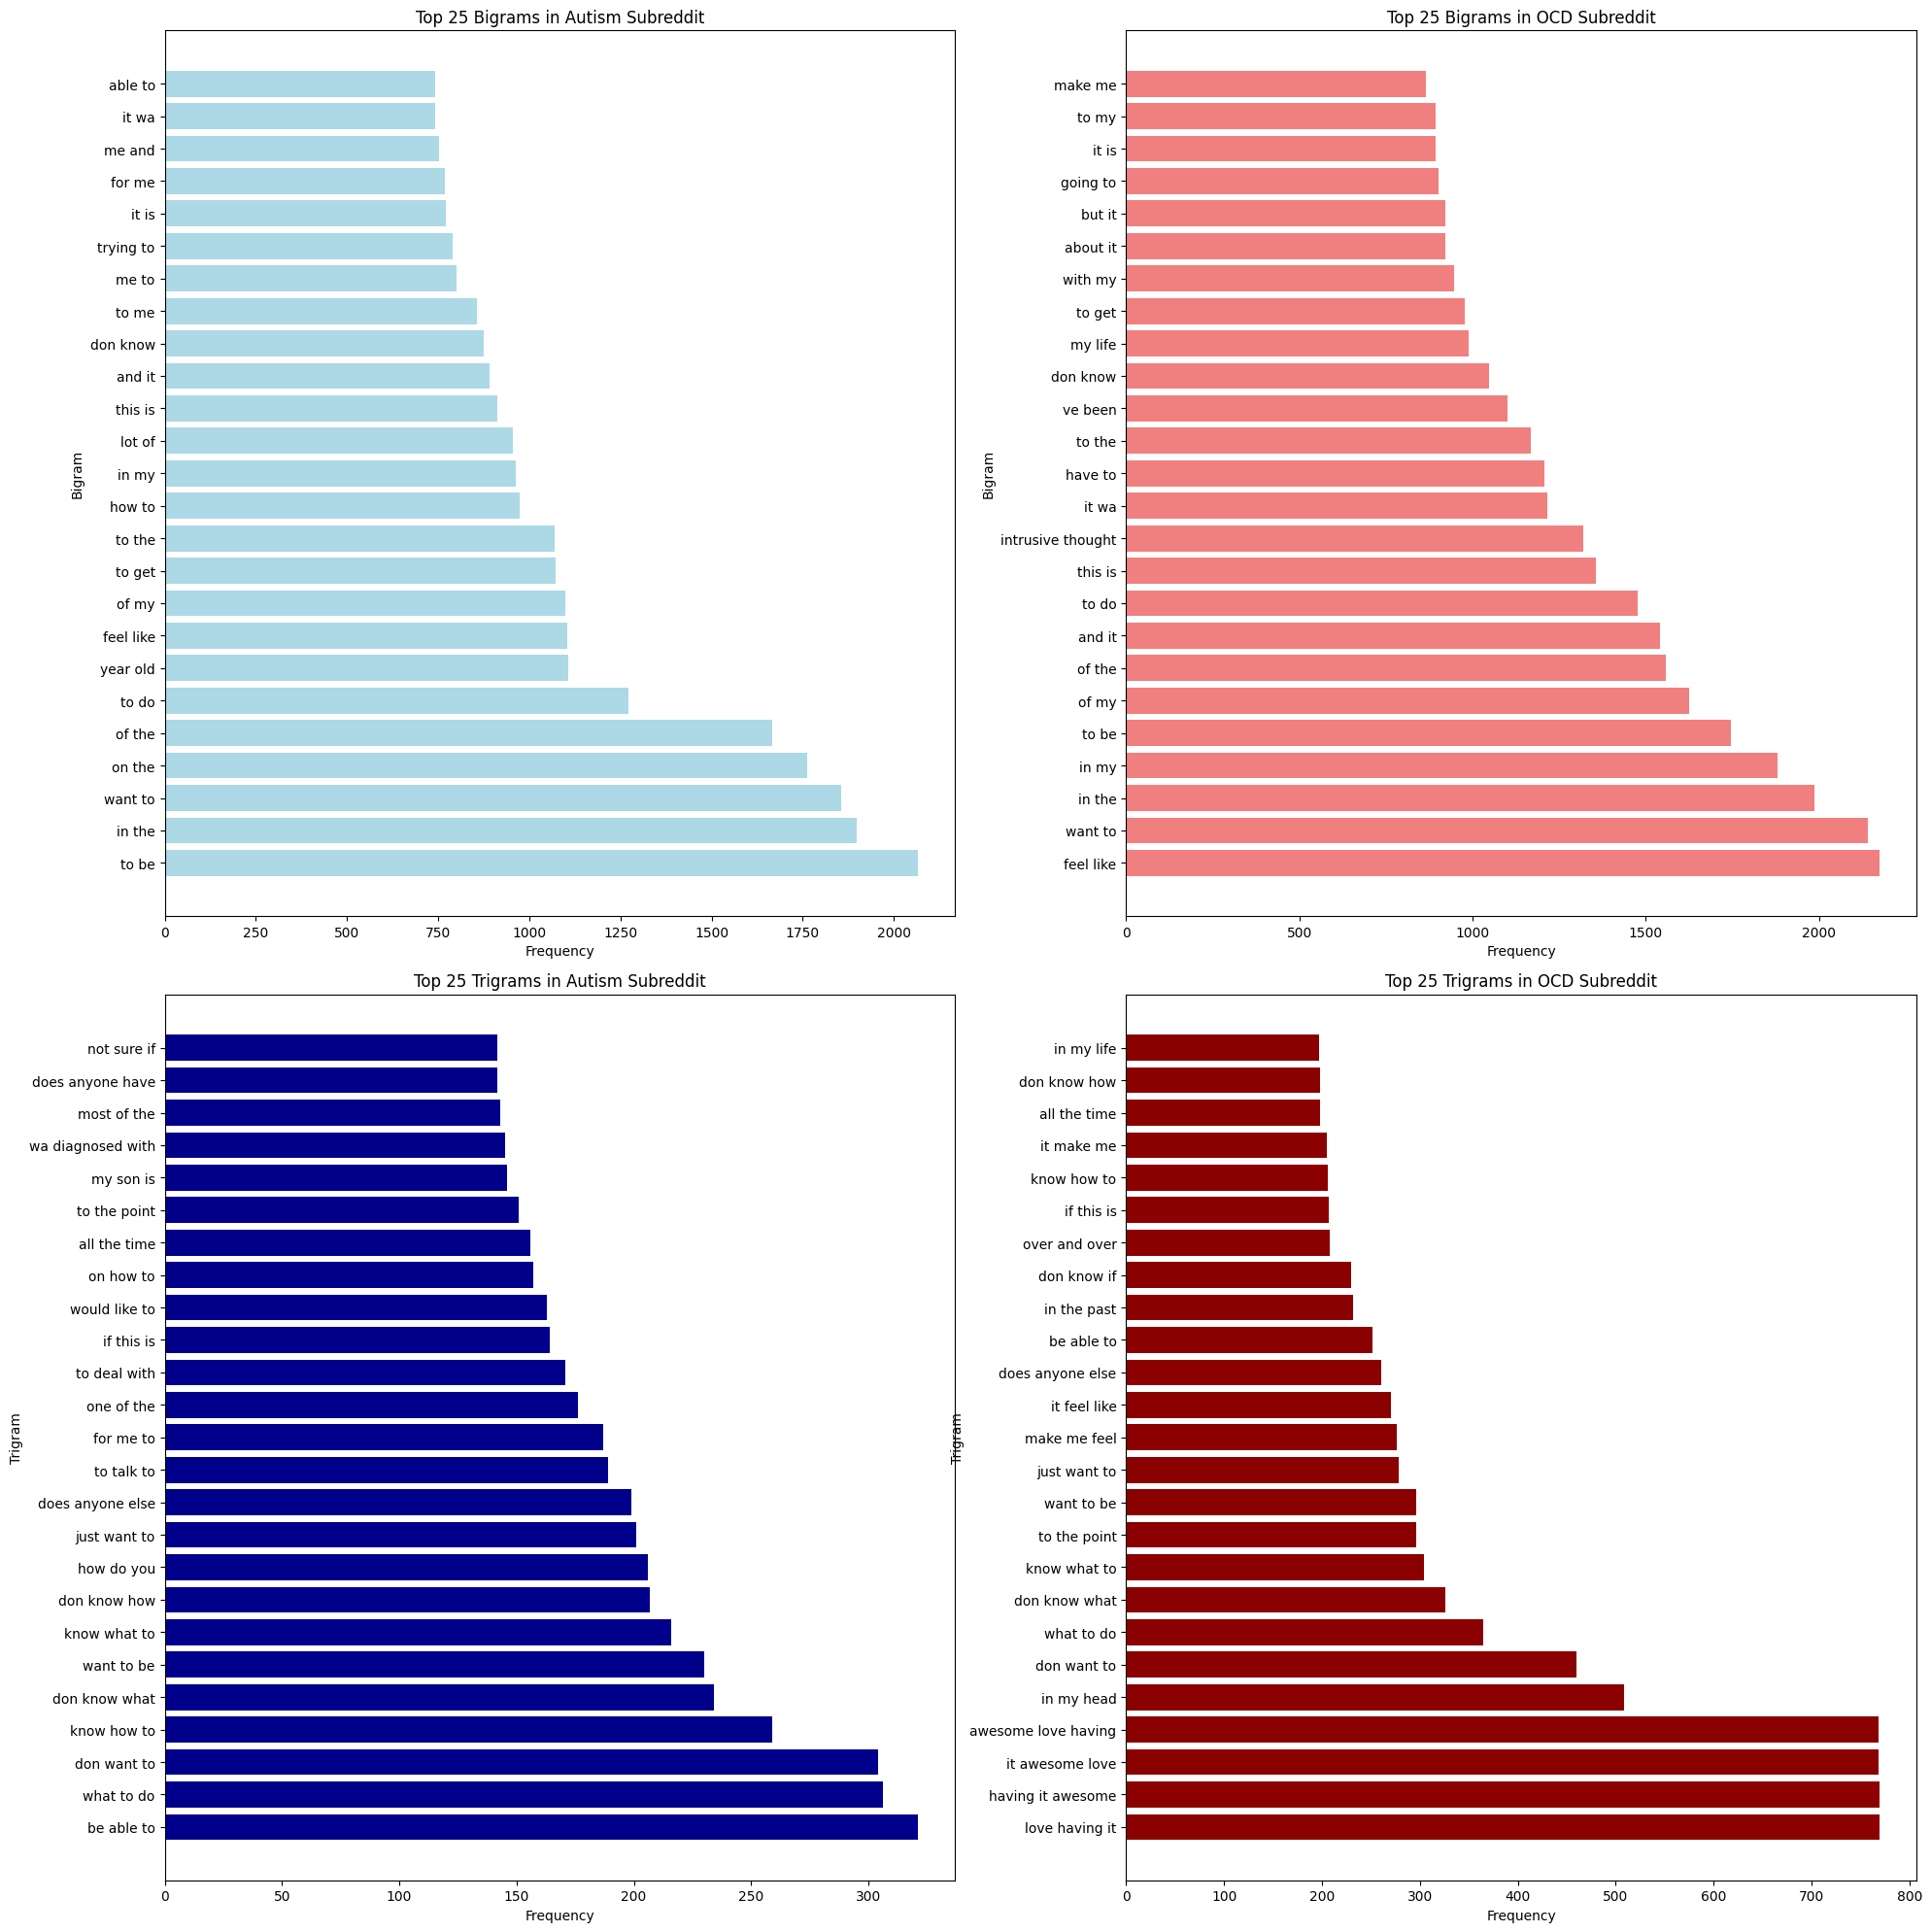

<Figure size 640x480 with 0 Axes>

In [ ]:
# Figure Design
# A four panel Figure
# Figure (1,0) - (upper left) - Top ten bigrams in r/Autism
# specs: a barplot sorted by frequency with a title, and x and y labels
# colors: for this plot the color is light blue.
# Figure (1,1) - (upper right) - Top ten bigrams in r/OCD
# specs: a barplot sorted by frequency with a title, and x and y labels
# colors: for this plot the color is light red.
# Figure (2,0) - (lower left) - Top ten trigrams in r/Autism
# specs: a barplot sorted by frequency with a title, and x and y labels
# colors: for this plot the color is dark blue.
# Figure (2,1) - (lower right) - Top ten trigrams in r/OCD
# specs: a barplot sorted by frequency with a title, and x and y labels
# colors: for this plot the color is dark red.

figure = plt.figure(figsize=(20,20))
# bigrams
ax1 = figure.add_subplot(221)
top_25_bigrams_aut = get_top_n_bigram(df_aut['selftext_lemmatized'], 25)
x, y = map(list, zip(*top_25_bigrams_aut))
ax1.barh(x, y, color='lightblue')
ax1.set_title('Top 25 Bigrams in Autism Subreddit')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Bigram')

ax2 = figure.add_subplot(222)
top_25_bigrams_ocd = get_top_n_bigram(df_ocd['selftext_lemmatized'], 25)
x, y = map(list, zip(*top_25_bigrams_ocd))
ax2.barh(x, y, color='lightcoral')
ax2.set_title('Top 25 Bigrams in OCD Subreddit')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Bigram')

# trigrams
ax3 = figure.add_subplot(223)
top_25_trigrams_aut = get_top_n_trigram(df_aut['selftext_lemmatized'], 25)
x, y = map(list, zip(*top_25_trigrams_aut))
ax3.barh(x, y, color='darkblue')
ax3.set_title('Top 25 Trigrams in Autism Subreddit')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Trigram')

ax4 = figure.add_subplot(224)
top_25_trigrams_ocd = get_top_n_trigram(df_ocd['selftext_lemmatized'], 25)
x, y = map(list, zip(*top_25_trigrams_ocd))
ax4.barh(x, y, color='darkred')
ax4.set_title('Top 25 Trigrams in OCD Subreddit')
ax4.set_xlabel('Frequency')
plt.tight_layout()
ax4.set_ylabel('Trigram')

plt.show()
plt.savefig('../images/top_25_bigrams_trigrams.png');

To be is used much more frequently as a bigram in the autism subreddit then in New York which is interesting from a linguistic perspective. Something that why was interesting to me as well was that intrusive thoughts showed up as a very common bigram in OCD and did not occur at all in the autism subreddit. Being able to and knowing what to do seems to be very important to autism users as their top trigrams indicate. OCD users are extremely focused on love having it having it awesome and it awesome love.

This illustrates top bigrams for autism and ocd. 

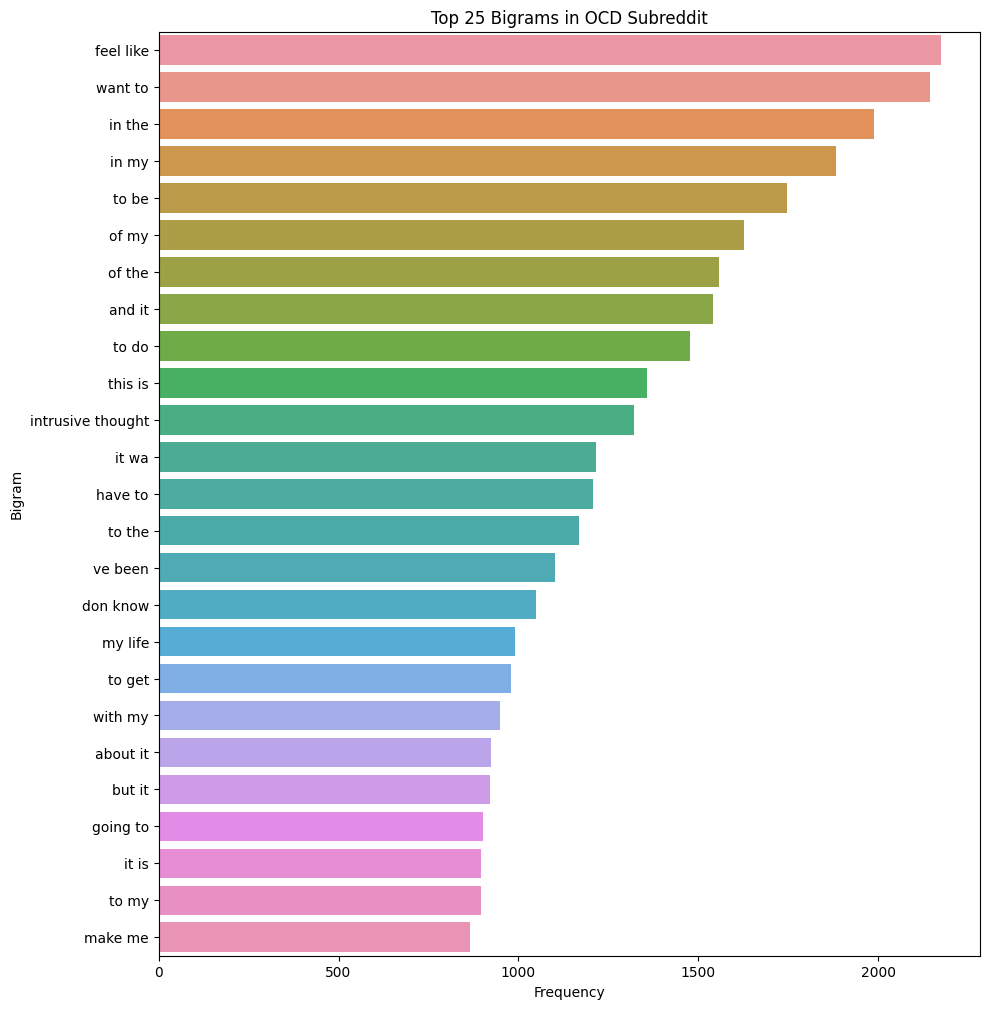

In [ ]:
top_25_bigrams_ocd = get_top_n_bigram(df_ocd['selftext_lemmatized'], 25)
x_ocd, y_ocd = map(list, zip(*top_25_bigrams_ocd))
plt.figure(figsize=(10,10))
sns.barplot(x=y_ocd,y=x_ocd)
plt.title('Top 25 Bigrams in OCD Subreddit')
plt.ylabel('Bigram')
plt.tight_layout()
plt.xlabel('Frequency')
plt.savefig('../images/top_25_bigrams_ocd.png');

`feel like` is the most common bigram in the `OCD` subreddit. This tracks with a diagnosis of OCD, as does the second in the list `intrusive thought`. Let's compare this with the `Autism` subreddit.

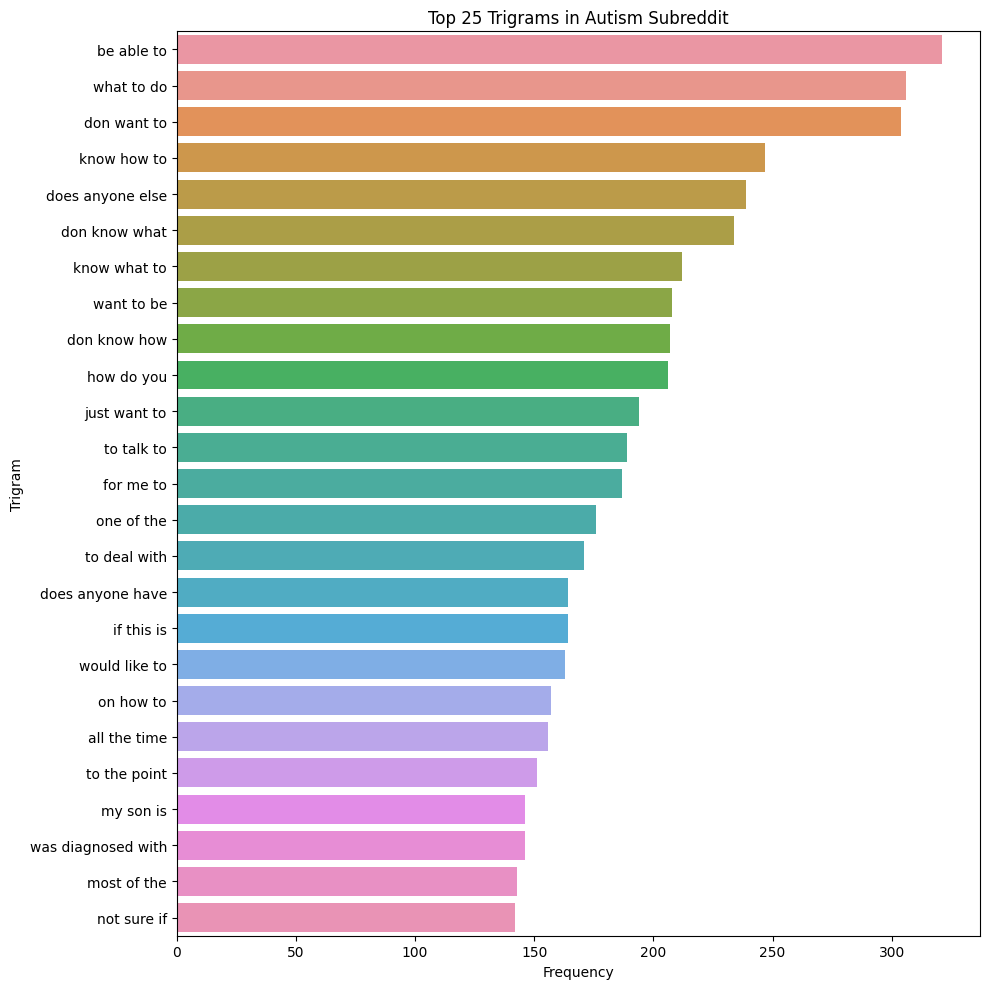

In [ ]:
top_25_trigrams_aut = get_top_n_trigram(df_aut['selftext'], 25)
x_aut_trigrams, y_aut_trigrams = map(list, zip(*top_25_trigrams_aut))
plt.figure(figsize=(10,10))
# horizontal bar plot
sns.barplot(x=y_aut_trigrams,y=x_aut_trigrams)
plt.title('Top 25 Trigrams in Autism Subreddit')
plt.ylabel('Trigram')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('../images/top_25_trigrams_aut.png');

See slides for more details.

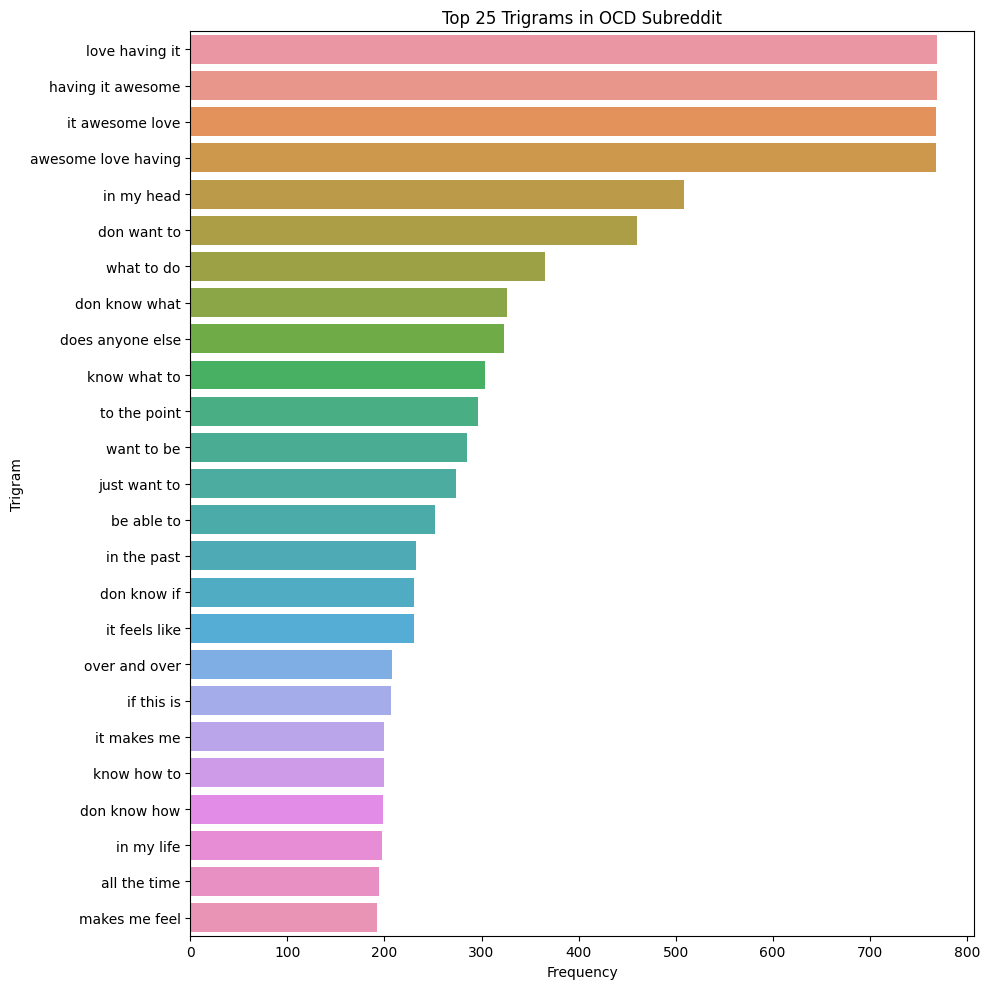

In [ ]:
top_25_trigrams_ocd = get_top_n_trigram(df_ocd['selftext'], 25)
x_ocd_trigrams, y_ocd_trigrams = map(list, zip(*top_25_trigrams_ocd))
plt.figure(figsize=(10,10))
# horizontal bar plot
sns.barplot(x=y_ocd_trigrams,y=x_ocd_trigrams)
plt.title('Top 25 Trigrams in OCD Subreddit')
plt.ylabel('Trigram')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('../images/top_25_trigrams_ocd.png');

Love having it is an interesting trigram for the `OCD` subreddit.

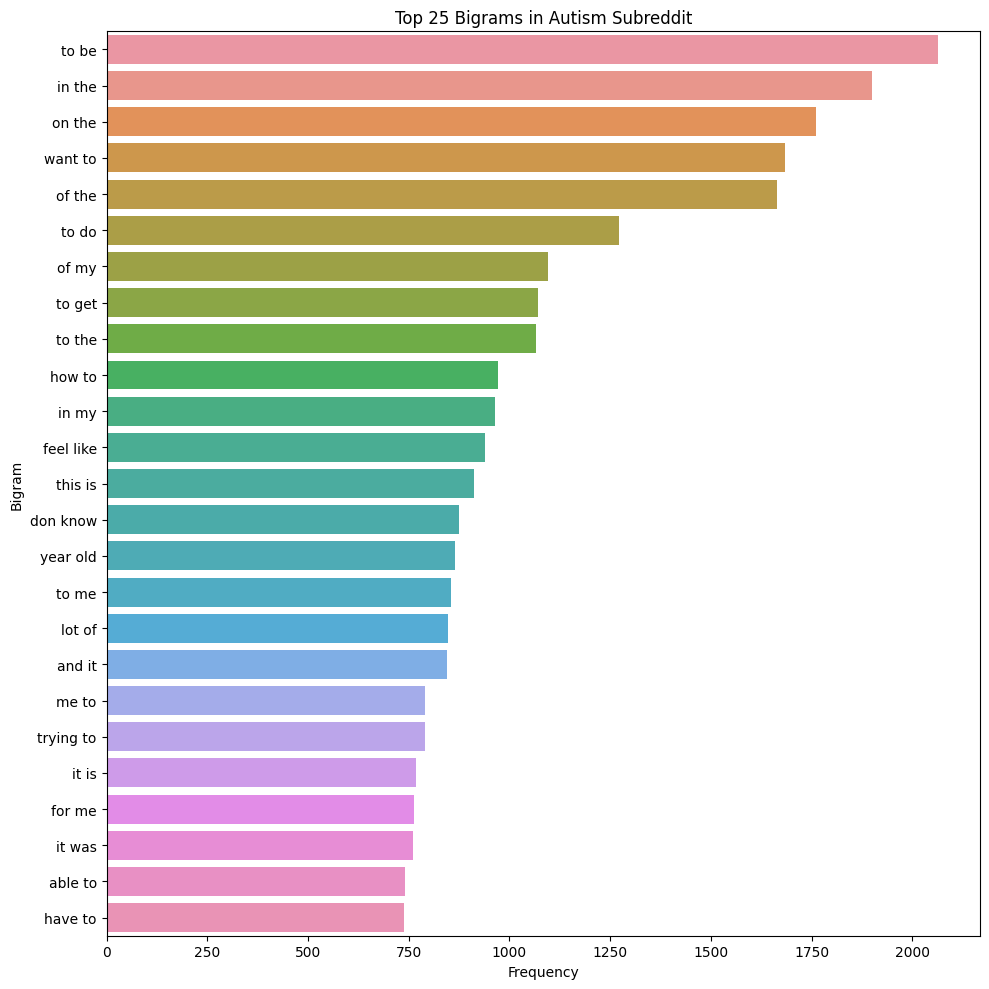

In [ ]:
# most common bigrams in the autism subreddit
top_25_bigrams_aut = get_top_n_bigram(df_aut['selftext'], 25)
x_aut, y_aut = map(list, zip(*top_25_bigrams_aut))
plt.figure(figsize=(10,10))
sns.barplot(x=y_aut,y=x_aut)
plt.title('Top 25 Bigrams in Autism Subreddit')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('../images/top_25_bigrams_aut.png');
# source: https://www.kaggle.com/rtatman/wordclouds-of-subreddit-headlines

to be, in the, on the, and want to, are the most common bigrams in the `Autism` subreddit.

In [ ]:
def get_top_n_words(text, n):
    vec = CountVectorizer().fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the top 100 words that appear in the autism subreddit
top_100_aut = get_top_n_words(df_aut['selftext'], 100000)
# print(f'top 100 words in autism subreddit: {top_100_aut}')
# get the words from this list
top_100_aut_words = [word for word, freq in top_100_aut]
#!print(f'the words: {top_100_aut_words}')
# get the top 100 words that appear in the ocd subreddit
top_100_ocd = get_top_n_words(df_ocd['selftext'], 100000)
# get the words from this list
top_100_ocd_words = [word for word, freq in top_100_ocd]
#!print(f'the words: {top_100_ocd_words}')
# get the first 25 words that the lists have in common
top_25_aut_ocd = [word for word in top_100_aut_words if word in top_100_ocd_words][:25]
print(f'top 25 words that appear in both subreddits: {top_25_aut_ocd}')

top 25 words that appear in both subreddits: ['to', 'and', 'the', 'my', 'it', 'of', 'that', 'is', 'in', 'with', 'me', 'for', 'have', 'but', 'he', 'this', 'was', 'or', 'on', 'you', 'like', 'be', 'so', 'not', 'just']


In [ ]:
# sample four posts from the autism subreddit
df_aut.sample(1)['selftext'].values[0]


"I think i have  I often get a sudden urge to touch, tap or stroke different objects or surfaces(no not that) on specific places or just the whole thing. If i dont do it i get a very wierd tense feeling in my fingertips and palms. I also get the need to beat the insides of my hands nd fingers very often to get the same kind of feeling to go away. Tapping my fingers againts a solid surface in a rythmic way usually helps with the stress from these instances.     Please tell me if there is a diagnosis for this behaviour. None of the people i ask about this know anything about it and think it's weird."

Consider the example post above. 

# User Analysis

In [ ]:
# I want to see the unique list of all users from the dataframe
unique_users = df['author'].unique() # this is a numpy array
print(f'There are {len(unique_users)} unique users in the dataframe')

There are 8949 unique users in the dataframe


## Top Users in the `OCD` Subreddit

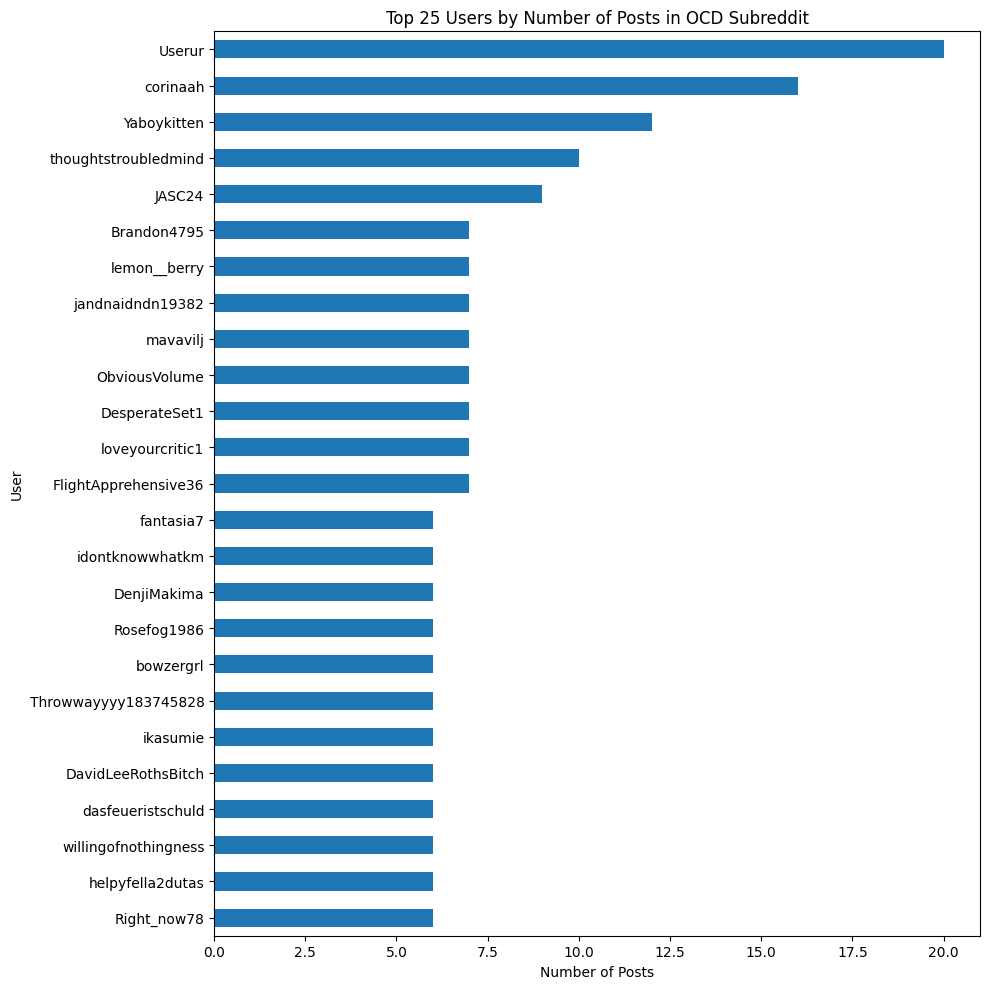

In [ ]:
# top 25 users by number of posts in the ocd subreddit
top_25_users_ocd_by_posts = df_ocd['author'].value_counts()[:25].sort_values(ascending=True)
top_25_users_ocd_by_posts.plot(kind='barh', figsize=(10,10))
plt.title('Top 25 Users by Number of Posts in OCD Subreddit')
plt.ylabel('User')
plt.xlabel('Number of Posts')
plt.savefig('../images/top_25_users_ocd_by_posts.png');
plt.tight_layout()
# plt.savefig('../images/legacy_top_25_users_ocd_by_posts.png');
# legacy figure
# before dropping [deleted] and [removed] users -- saved as legacy_top_25_users_ocd_by_posts.png


The legacy plot showed that there are a large number of posts that have the author deleted which could mean a deactivated account. This is not a problem for the model as it will not be using the author's name as a feature. It would be useful to remove the posts with the author deleted though as they are not useful for the model.

The updated figure shows the top users by number of posts in the thread. In comparison to the autism thread the top user on the ocd thread posted almost 140 times which is more than double the top user on the autism thread. 

In [ ]:
stopwords_list.append('I')
stopwords_list.append('like')

# append all words starting with I and length of 2 to 4 to the stopwords list
# for example: I'm, I've etc.
for word in df_ocd['selftext_lemmatized'].str.split(expand=True).stack().value_counts().index:
    if word.startswith('I') and len(word) <= 4:
        stopwords_list.append(word)


In [ ]:
# add 'I' to the list of stopwords
# dict of users and their most common word
users_ocd = df_ocd['author'].value_counts().index
users_ocd_most_common_word = {}
for user in users_ocd:
    user_df = df_ocd[df_ocd['author'] == user]
    user_df = user_df['selftext'].str.split(expand=True).stack().value_counts()[:50].sort_values(ascending=True)
    # most common words are in user_df.index, go from most to least common and pick the first one that is not in the stop words list
    for word in user_df.index:
        if word not in stopwords_list: # if the word is not in the stop words list
            users_ocd_most_common_word[user] = word
            #print(f'{user} most common word: {word}')
            break # break out of the for loop


In [ ]:
# add 'I' to the list of stopwords
# dict of users and their most common word
users_aut = df_aut['author'].value_counts().index
users_aut_most_common_word = {}
for user in users_aut:
    user_df = df_aut[df_aut['author'] == user]
    user_df = user_df['selftext'].str.split(expand=True).stack().value_counts()[:50].sort_values(ascending=True)
    # most common words are in user_df.index, go from most to least common and pick the first one that is not in the stop words list
    for word in user_df.index:
        if word not in stopwords_list: # if the word is not in the stop words list
            users_aut_most_common_word[user] = word
            #print(f'{user} most common word: {word}')
            break # break out of the for loop

During the data exploration phase I process the users in the OCD thread to determine the most common words they used and the top 50 words used for each author. I then use these values as annotations on a Matplotlib visual shown below.

Create a dictionary with the users top words

During the data cleaning process I also create two data frames one for the r/ocd posts and the other for the r/autism posts. These are named df_ocd and df_aut respectively. I loop through the words in the self-text lemmatized field to determine all words that start with I and are less than or equal to four characters in length to append to my stop words list for the visualization below.

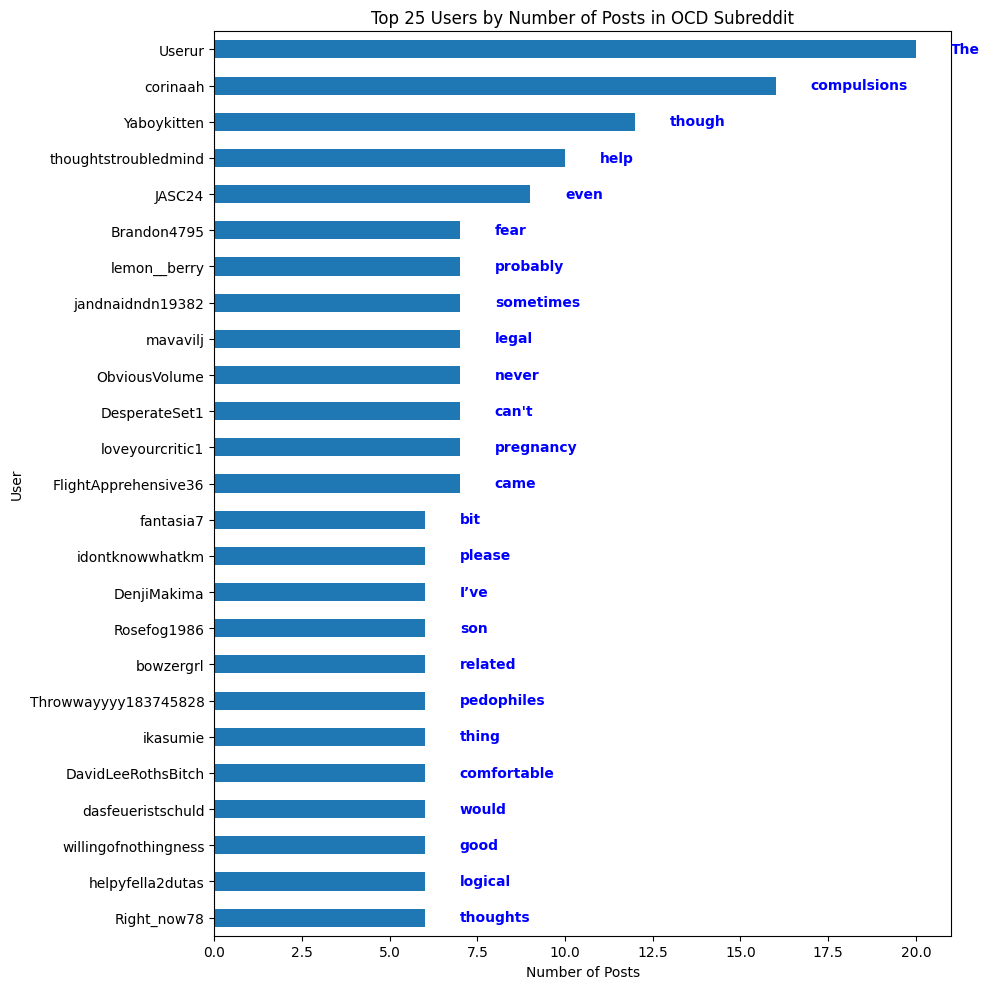

In [ ]:
# Repeat the plot above but add the word that the user uses most often in their posts as an annotation at the end of their bar in the chart.
top_25_users_ocd_by_posts.plot(kind='barh', figsize=(10,10))
plt.title('Top 25 Users by Number of Posts in OCD Subreddit')
plt.ylabel('User')
plt.xlabel('Number of Posts')
# add the word that the user uses most often in their posts as an annotation at the end of their bar in the chart

# add the word that the user uses most often in their posts as an annotation at the end of their bar in the chart
for i, v in enumerate(top_25_users_ocd_by_posts):
    try:
        plt.text(v + 1, i -0.1, users_ocd_most_common_word[top_25_users_ocd_by_posts.index[i]], color='blue', fontweight='bold')
    except KeyError:
        pass
plt.tight_layout()
plt.savefig('../images/top_25_users_ocd_by_posts_with_word.png');
plt.show()

These are words used by the top 25 users of ocd.

## Top Users in the `Autism` Subreddit

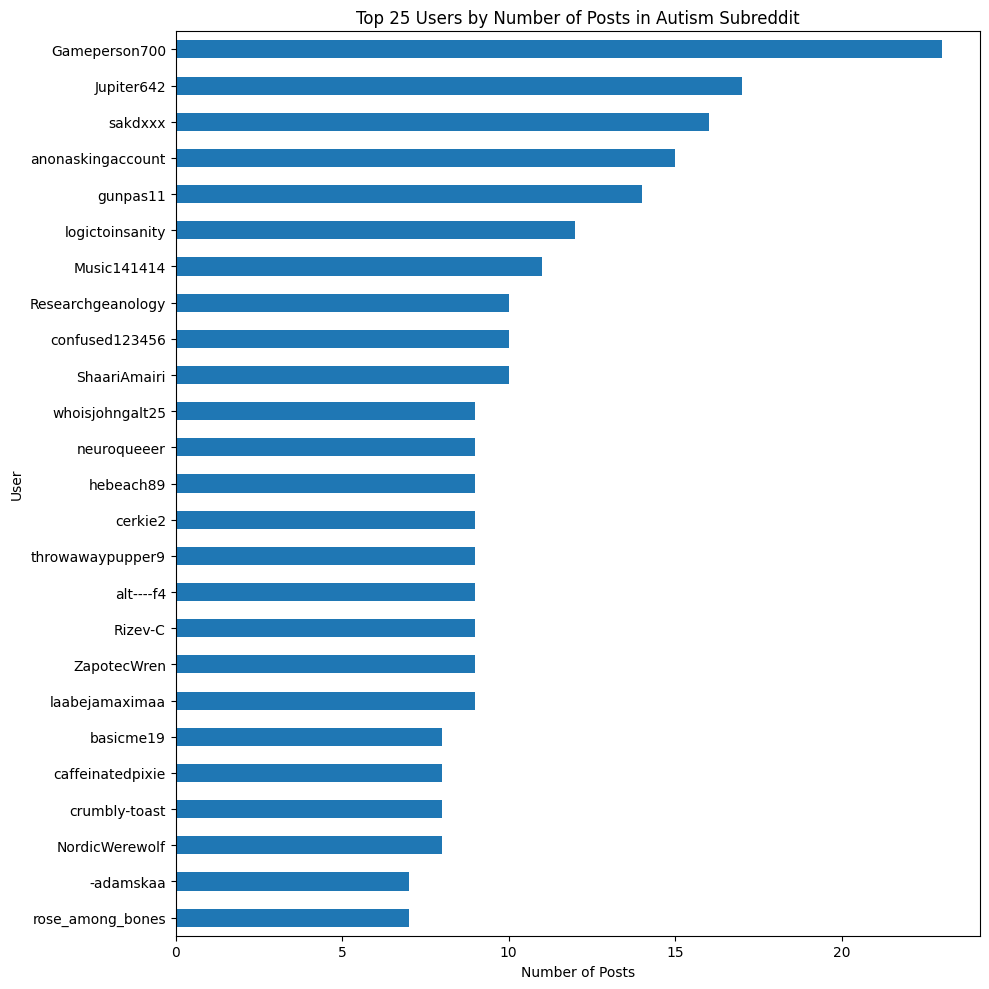

In [ ]:
# top 25 users by number of posts in the autism subreddit
top_25_users_aut_by_posts = df_aut['author'].value_counts()[:25].sort_values(ascending=True)
top_25_users_aut_by_posts.plot(kind='barh', figsize=(10,10))
plt.title('Top 25 Users by Number of Posts in Autism Subreddit')
plt.ylabel('User')
plt.xlabel('Number of Posts')
plt.tight_layout()
plt.savefig('../images/top_25_users_aut_by_posts.png')
# legacy
# plt.savefig('../images/legacy_top_25_users_aut_by_posts.png');
# before dropping [deleted] and [removed] users -- saved as legacy_top_25_users_aut_by_posts.png
plt.show();

Now repeating the process with the autism thread.

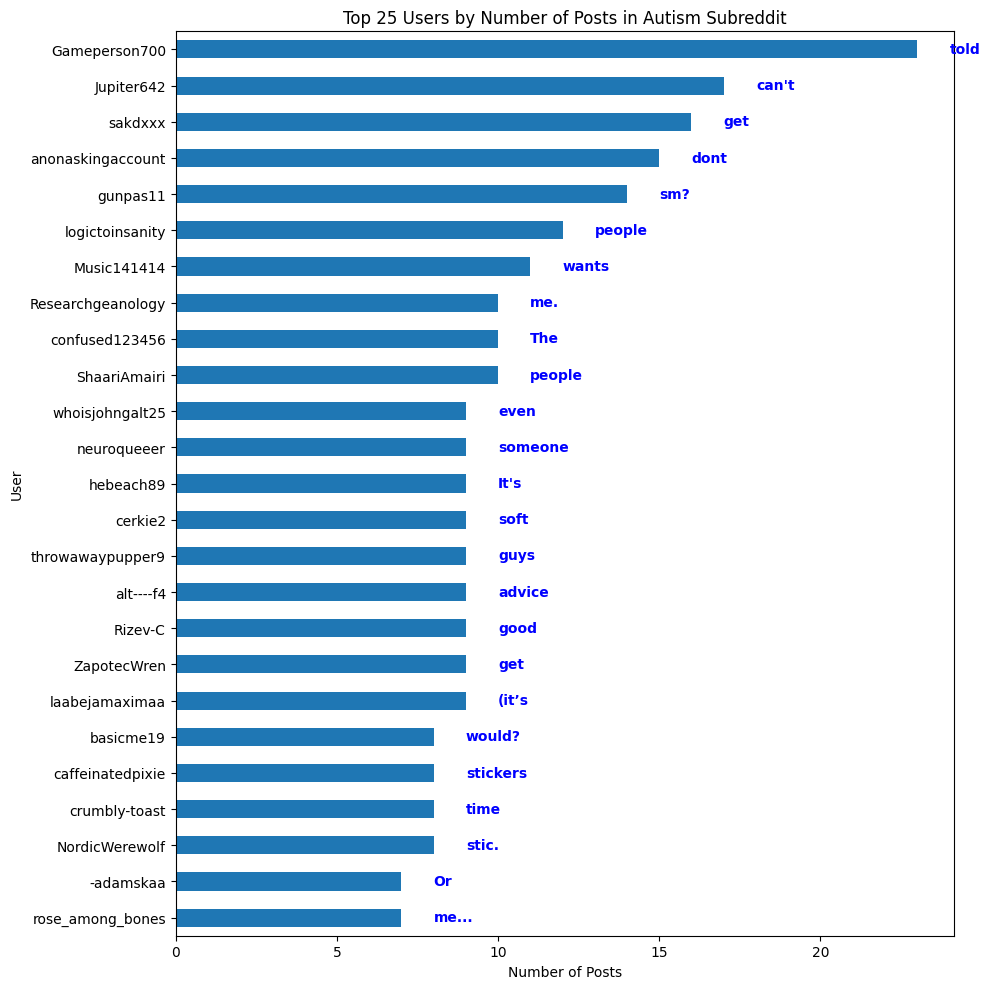

In [ ]:
# Repeat the plot above but add the word that the user uses most often in their posts as an annotation at the end of their bar in the chart.
top_25_users_aut_by_posts.plot(kind='barh', figsize=(10,10))
plt.title('Top 25 Users by Number of Posts in Autism Subreddit')
plt.ylabel('User')
plt.xlabel('Number of Posts')
# add the word that the user uses most often in their posts as an annotation at the end of their bar in the chart
plt.tight_layout()
# add the word that the user uses most often in their posts as an annotation at the end of their bar in the chart
for i, v in enumerate(top_25_users_aut_by_posts):
    plt.text(v + 1, i -0.1, users_aut_most_common_word[top_25_users_aut_by_posts.index[i]], color='blue', fontweight='bold')
plt.tight_layout()
plt.savefig('../images/top_25_users_aut_by_posts_with_word.png');
plt.show()

The top user on the autism thread posted the word `told` the most of all their words (that are not stop words). 

## Post Frequency for Users in the `OCD` Subreddit

/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_28865/2809961584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ocd['created_utc'] = pd.to_datetime(df_ocd['created_utc'], unit='s')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_28865/2809961584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aut['created_utc'] = pd.to_datetime(df_aut['created_utc'], unit='s')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_28865/2809961584.py:6: SettingWithCopyWarning: 
A val

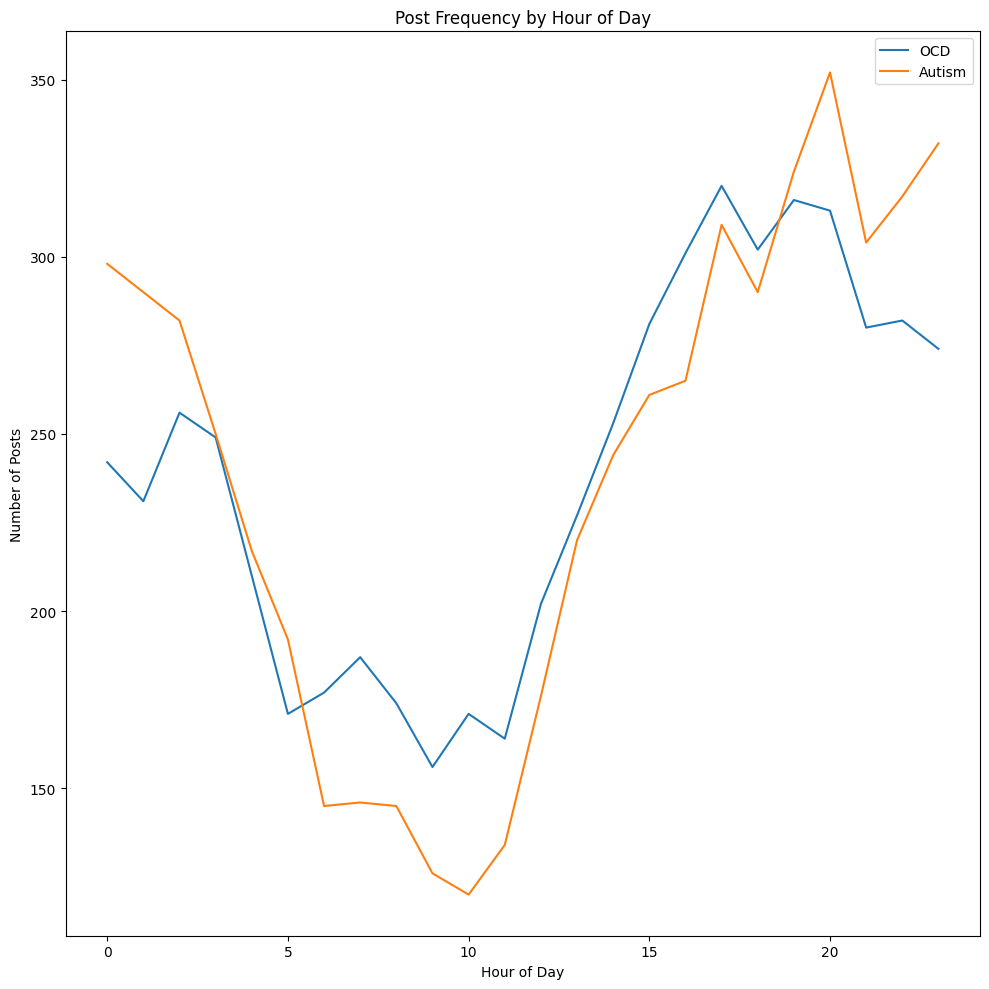

In [ ]:
# post frequency by hour of day
# cast the created_utc column to datetime for ocd and autism subreddits
df_ocd['created_utc'] = pd.to_datetime(df_ocd['created_utc'], unit='s')
df_aut['created_utc'] = pd.to_datetime(df_aut['created_utc'], unit='s')

df_ocd['hour'] = df_ocd['created_utc'].dt.hour
df_aut['hour'] = df_aut['created_utc'].dt.hour

# plot the post frequency by hour of day
df_ocd['hour'].value_counts().sort_index().plot(kind='line', figsize=(10,10))
df_aut['hour'].value_counts().sort_index().plot(kind='line', figsize=(10,10))
plt.title('Post Frequency by Hour of Day')
plt.ylabel('Number of Posts')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.legend( ('OCD', 'Autism'), loc='upper right')
plt.savefig('../images/post_frequency_by_hour_of_day.png')
plt.show();


The visual above shows the post frequency by hour for the two threads. They both pick up in the evening but OCD has a notable increase in posts early in the day at around 7:00 AM compared to autism which has its minimum at 10:00 AM.

# Sources

https://clincalc.com/DrugStats/Top300Drugs.aspx